# Experimenting with Movie Lens 100k

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../Library')

from Metrics.NMSE import NMSE
from Modules.GaussianDictionaryFilter import GaussianDictionaryFilter as DictionaryFilter
from Modules.NMF import NMF
from Modules.MVGMF import MVGMF

from sklearn.model_selection import train_test_split
from AdvancedModelSelection import user_based_train_test_split

import matplotlib.pyplot as plt
import tensorflow as tf
import time

2024-07-20 20:22:01.102330: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 20:22:01.423672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 20:22:02.191571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Read the dataset
dataset = pd.read_csv('../Data/MovieLens/Small/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,356,137,4.0
1,708,91,2.0
2,411,300,4.0
3,55,59,4.0
4,894,196,3.0


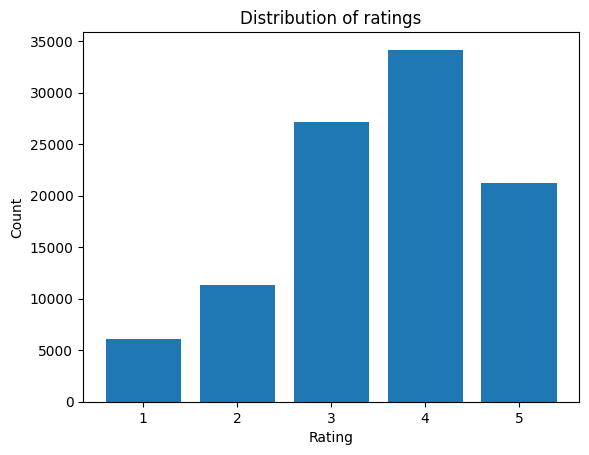

In [3]:
# Plot the distribution of ratings
rating_counts = dataset['Rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [4]:
# Split the dataset into train and test data
train_val_data, test_data = user_based_train_test_split(dataset, test_size=0.2, random_state=42)

# Split the train and validation data
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (72000, 3)
Validation data shape: (8000, 3)
Test data shape: (20000, 3)


In [5]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1

In [6]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert validation data to sparse tensor
val_sparse_tensor = tf.sparse.SparseTensor(
    indices=val_data[['Movie Index', 'User Index']].values,
    values=val_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-20 20:22:03.804370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 20:22:04.027845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 20:22:04.027885: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 20:22:04.029653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 20:22:04.029693: I external/local_xla/xla/stream_executor

## NMF

In [7]:
def fit_nmf(num_movies, num_users, num_factors, init_scale, num_epochs, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor):
    """
    Fits a NMF model to the data and returns the training and testing NMSEs.
    """

    # Initialize variables
    nmf_train_nmse = []
    nmf_val_nmse = []
    nmf_test_nmse = []

    # Create the model
    nmf = NMF(m = num_movies, n = num_users, num_factors=num_factors, init_scale=init_scale)
    train_nmse = NMSE()
    val_nmse = NMSE()
    test_nmse = NMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    val_tensor = tf.cast(tf.sparse.to_dense(val_sparse_tensor), tf.float32)
    val_mask = tf.cast(tf.not_equal(val_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        nmf(train_tensor, train_mask)
        pred = tf.matmul(nmf.C, nmf.X)

        train_nmse.update_state(train_tensor, pred, train_mask)
        val_nmse.update_state(val_tensor, pred, val_mask)
        test_nmse.update_state(test_tensor, pred, test_mask)

        nmf_train_nmse.append(train_nmse.result().numpy())
        nmf_val_nmse.append(val_nmse.result().numpy())
        nmf_test_nmse.append(test_nmse.result().numpy())
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return nmf_train_nmse, nmf_val_nmse, nmf_test_nmse, time_taken

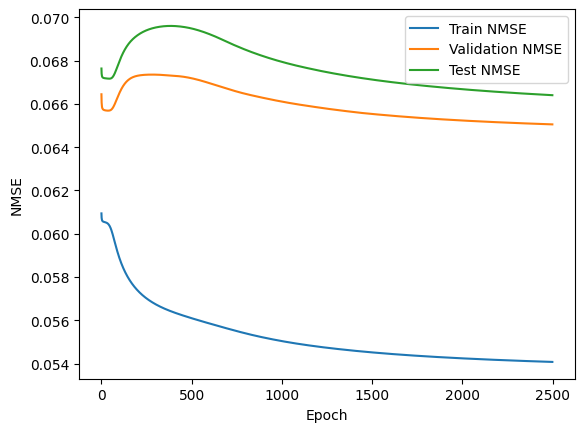

Time taken: 8.11 seconds


In [12]:
# Validate the algorithm
nmf_train_nmse, nmf_val_nmse, nmf_test_nmse, time_taken = fit_nmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, 2500, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(nmf_train_nmse, label='Train NMSE')
plt.plot(nmf_val_nmse, label='Validation NMSE')
plt.plot(nmf_test_nmse, label='Test NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

## PMF

## BPMF

## MVGMF

In [19]:
def fit_mvgmf(num_movies, num_users, num_factors, k, sigma, init_scale, num_epochs, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor):
    """
    Fits a MVGMF model to the data and returns the training and testing NMSEs.
    """

    # Initialize variables
    mvgmf_train_nmse = []
    mvgmf_val_nmse = []
    mvgmf_test_nmse = []

    # Create the model
    mvgmf = MVGMF(m = num_movies, n = num_users, num_factors=4, k=k, sigma=sigma, init_scale=init_scale)
    train_nmse = NMSE()
    val_nmse = NMSE()
    test_nmse = NMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    val_tensor = tf.cast(tf.sparse.to_dense(val_sparse_tensor), tf.float32)
    val_mask = tf.cast(tf.not_equal(val_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        mvgmf(train_tensor, train_mask)
        pred = tf.matmul(mvgmf.C, mvgmf.X)

        train_nmse.update_state(train_tensor, pred, train_mask)
        val_nmse.update_state(val_tensor, pred, val_mask)
        test_nmse.update_state(test_tensor, pred, test_mask)

        mvgmf_train_nmse.append(train_nmse.result().numpy())
        mvgmf_val_nmse.append(val_nmse.result().numpy())
        mvgmf_test_nmse.append(test_nmse.result().numpy())

    end_time = time.time()
    time_taken = end_time - start_time

    return mvgmf_train_nmse, mvgmf_val_nmse, mvgmf_test_nmse, time_taken

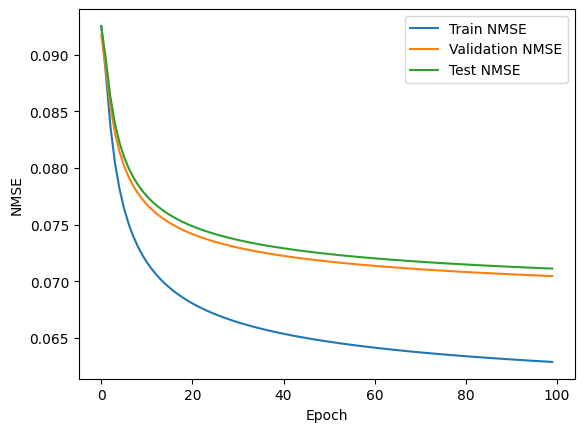

Time taken: 29.46 seconds


In [20]:
# Validate the algorithm
mvgmf_train_nmse, mvgmf_val_nmse, mvgmf_test_nmse, time_taken = fit_mvgmf(NUM_MOVIES, NUM_USERS, 4, 40, 0.2, dataset['Rating'].mean() / 4, 100, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(mvgmf_train_nmse, label='Train NMSE')
plt.plot(mvgmf_val_nmse, label='Validation NMSE')
plt.plot(mvgmf_test_nmse, label='Test NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

## Dictionary filter

In [35]:
def create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor):
    """
    Create a TF dataset from the sparse tensors.
    """
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=num_users // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=num_users // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=num_users // batch_size, axis=1)
        for i in range(num_users // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32),
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32),
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32)
        )
    )

    return dataset

In [36]:
def fit_df(num_movies, num_users, num_factors, init_scale, train_lambda, batch_size, num_epochs, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor):
    """
    Fits a Dictionary Filter model to the data and returns the training and testing NMSEs.
    """

    # Initialize variables
    df_train_nmse = np.zeros(num_epochs)
    df_val_nmse = np.zeros(num_epochs)
    df_test_nmse = np.zeros(num_epochs)

    # Create the model
    model = DictionaryFilter(num_movies, num_factors, init_scale, train_lambda)
    train_nmse = NMSE()
    val_nmse = NMSE()
    test_nmse = NMSE()

    # Create the dataset
    dataset = create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        for train_batch, val_batch, test_batch in dataset:
            x = model(train_batch)
            train_nmse.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            val_nmse.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            test_nmse.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))

        df_train_nmse[epoch] = train_nmse.result().numpy()
        df_val_nmse[epoch] = val_nmse.result().numpy()
        df_test_nmse[epoch] = test_nmse.result().numpy()

    end_time = time.time()
    time_taken = end_time - start_time

    return df_train_nmse, df_val_nmse, df_test_nmse, time_taken

2024-07-20 20:56:10.128195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-20 20:56:11.112812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-20 20:56:12.074881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-20 20:56:13.122579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-20 20:56:14.284411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-20 20:56:15.393607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-20 20:56:16.544291: W tensorflow/core/framework/local_rendezvous.cc:404] L

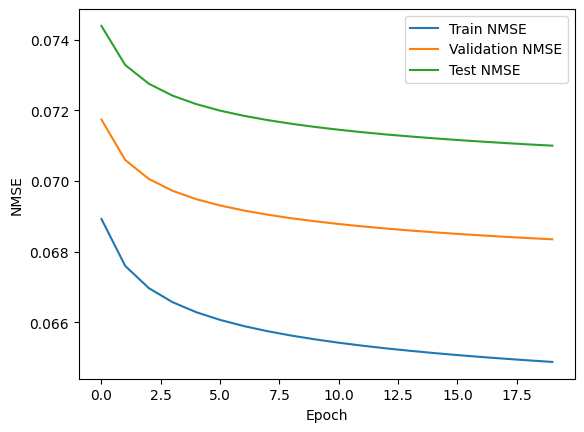

Time taken: 21.98 seconds


In [38]:
# Validate the algorithm
df_train_nmse, df_val_nmse, df_test_nmse, time_taken = fit_df(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, 2.0, 32, 20, train_sparse_tensor, val_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(df_train_nmse, label='Train NMSE')
plt.plot(df_val_nmse, label='Validation NMSE')
plt.plot(df_test_nmse, label='Test NMSE')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')